In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob
from itertools import product
from functools import partial

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

import pandas as pd
import seaborn as sns

from pathlib import Path
from sbibm.utils.io import get_tensor_from_csv

from notebook import nre_gamma_default, prepare_df_for_plot, get_metrics, figsize, wide_to_long

import numpy as np

In [3]:
linestyles = {2: "dashed", 3: "solid"}
avglogratio_name = r"Mean -$\log \hat{r}_{\mathbf{w}}(\mathbf{x} \mid \mathbf{\theta})$"
mi0_axes_label = r"$-\hat{I}^{(0)}_{w}(\theta; x)$"
mi1_axes_label = r"$-\hat{I}^{(1)}_{w}(\theta; x)$"
partition_fn_name = r"log $\hat{Z}_{w}(x)$"
legend_title = "Contrastive" + "\n" + "parameters"
alpha=0.7

height = 2.5

def plot_avg_log_ratios(path: pd.Series, num_blocks: pd.Series, **kwargs):
    ax = plt.gca()
    for index in path.index:
        ax.plot(
            -get_tensor_from_csv(Path(path[index]) / "avg_log_ratios.csv"), linestyle=linestyles[num_blocks[index]], 
            alpha=alpha,
            **kwargs
        )
    ax.set_xscale("log")

def plot_validation_loss(path: pd.Series, num_blocks: pd.Series, **kwargs):
    ax = plt.gca()
    for index in path.index:
        ax.plot(
            get_tensor_from_csv(Path(path[index]) / "validation_loss.csv"), 
            linestyle=linestyles[num_blocks[index]], 
            alpha=alpha,
            **kwargs
        )
    ax.set_xscale("log")
    ax.set_yscale("log")

    
def get_first_of_group(df: pd.DataFrame) -> pd.DataFrame:
    grp = df.groupby(["task", "algorithm", "gamma", "num_blocks", "num_contrastive_parameters"])
    return grp.first().reset_index()

In [4]:
# roots = [
#     "/home/ben/sci/cnre/infinite/outputs/2022-06-09/16-01-25/",
#     "/home/ben/sci/cnre/infinite/outputs/2022-06-09/16-07-20/",
# ]
# ks = [2, 10]

# fig, ax = plt.subplots()

# for root, k in zip(roots, ks):
#     p0 = root + "path_mutual_information_0s.csv"
#     p1 = root + "path_mutual_information_1s.csv"
#     ax.plot(get_tensor_from_csv(p0), label=f"mi0-{k}")
#     ax.plot(get_tensor_from_csv(p1), label=f"mi1-{k}")
#     ax.set_ylim(-4.0, 6.0)
# ax.legend()

In [5]:
# linestyles = {2: "dashed", 3: "solid"}
# avglogratio_name = r"Mean -$\log \hat{r}_{\mathbf{w}}(\mathbf{x} \mid \mathbf{\theta})$"
# mi0_axes_label = "Mean validation loss"
# legend_title = "Contrastive" + "\n" + "parameters"
# alpha=0.7

# height = 2.5



# def plot_avg_log_ratios(path: pd.Series, num_blocks: pd.Series, **kwargs):
#     ax = plt.gca()
#     for index in path.index:
#         ax.plot(
#             -get_tensor_from_csv(Path(path[index]) / "avg_log_ratios.csv"), linestyle=linestyles[num_blocks[index]], 
#             alpha=alpha,
#             **kwargs
#         )
#     ax.set_xscale("log")

    
# def plot_validation_loss(path: pd.Series, num_blocks: pd.Series, **kwargs):
#     ax = plt.gca()
#     for index in path.index:
#         ax.plot(
#             get_tensor_from_csv(Path(path[index]) / "validation_loss.csv"), 
#             linestyle=linestyles[num_blocks[index]], 
#             alpha=alpha,
#             **kwargs
#         )
#     ax.set_xscale("log")

    
# def get_first_of_group(df: pd.DataFrame) -> pd.DataFrame:
#     grp = df.groupby(["task", "algorithm", "gamma", "num_blocks", "num_contrastive_parameters"])
#     return grp.first().reset_index()


def plot_either_val_or_avglogratio_or_mi(path: pd.Series, metric: pd.Series, num_blocks: pd.Series, **kwargs):
    ax = plt.gca()
    for index in path.index:
        if metric[index] == "validation":
            time_series = get_tensor_from_csv(Path(path[index]) / "validation_loss.csv")
            yscale = "log"
        elif metric[index] == "avglogratio":
            time_series = -get_tensor_from_csv(Path(path[index]) / "avg_log_ratios.csv")
            # yscale = "symlog"
            yscale = "linear"
        elif metric[index] == "mi0":
            time_series = -get_tensor_from_csv(Path(path[index]) / "mutual_information_0s.csv")
            yscale = "linear"
            # yscale = "symlog"
        elif metric[index] == "mi1":
            time_series = -get_tensor_from_csv(Path(path[index]) / "mutual_information_1s.csv")
            yscale = "linear"
        elif metric[index] == "log_zs":
            time_series = get_tensor_from_csv(Path(path[index]) / "avg_log_zs.csv")
            yscale = "linear"
        else:
            raise NotImplementedError(metric[index])
        ax.plot(time_series, linestyle=linestyles[num_blocks[index]], alpha=alpha, **kwargs)
    ax.set_xscale("log")
    ax.set_yscale(yscale)

In [6]:
df = get_metrics(
    [
        "fix-bench.csv",
    ],
    "mi",
)
df = df[(df["task"] == "slcp") & (df["num_blocks"] == 3)]
df["gamma"] = df["gamma"].fillna(nre_gamma_default)

## partition function

dict_keys([('log_zs', 0.001), ('log_zs', 0.01), ('log_zs', 0.1), ('log_zs', 1.0), ('log_zs', 10.0), ('log_zs', 100.0)])


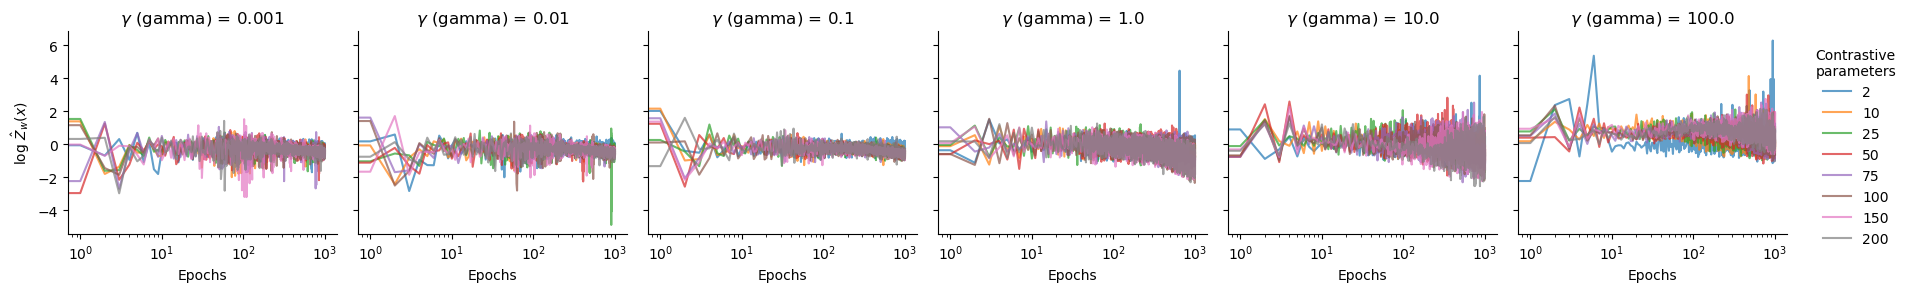

In [7]:
df_cnre = df[
    (df["algorithm"] == "CNRE")
    & (df["task"] == "slcp")
    & (df["num_blocks"] == 3)
].copy()

df_cnre["metric"] = "log_zs"

grp = df_cnre.groupby(["task", "algorithm", "gamma", "num_blocks", "num_contrastive_parameters", "metric"])
df_cnre = grp.first().reset_index()

g = sns.FacetGrid(
    df_cnre, 
    hue="num_contrastive_parameters",
    row="metric",
    col="gamma", 
    height=3,
    sharey="row",
    # legend_out=True,
    legend_out=False
)

g.figure.tight_layout()
g.map(plot_either_val_or_avglogratio_or_mi, "path", "metric", "num_blocks")

g.add_legend()
sns.move_legend(g, "center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
g.legend.set_title(legend_title)

print(g.axes_dict.keys())

ax = g.axes_dict[('log_zs', 0.001)]
ax.set_ylabel(partition_fn_name)

for ax in g.axes[0, :]:
    value = ax.get_title().split()[-1]
    ax.set_title(fr"$\gamma$ (gamma) = {value}")
    ax.set_xlabel("Epochs")

ylim = ax.get_ylim()
plt.savefig("z-slcp-nrec.pdf", dpi=300, bbox_inches="tight")

dict_keys(['log_zs'])


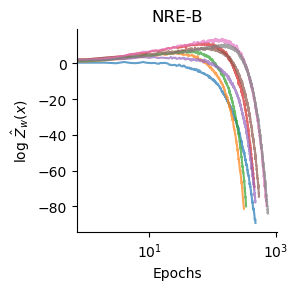

In [8]:
df_nreb = df[
    (df["algorithm"] == "NRE-B")
    & (df["task"] == "slcp")
    & (df["num_blocks"] == 3)
].copy()

df_nreb["metric"] = "log_zs"

grp = df_nreb.groupby(["task", "algorithm", "num_blocks", "num_contrastive_parameters", "metric"])
df_nreb = grp.first().reset_index()

g = sns.FacetGrid(
    df_nreb, 
    hue="num_contrastive_parameters",
    row="metric",
    # col="gamma", 
    height=3,
    sharey="row",
    # legend_out=True,
    legend_out=False
)

g.figure.tight_layout()
g.map(plot_either_val_or_avglogratio_or_mi, "path", "metric", "num_blocks")

# g.add_legend()
# sns.move_legend(g, "center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
# g.legend.set_title(legend_title)

print(g.axes_dict.keys())

ax = g.axes_dict[('log_zs')]
ax.set_ylabel(partition_fn_name)
# ax.set_ylim(*ylim)

for ax in g.axes[0, :]:
    value = ax.get_title().split()[-1]
    ax.set_title(r"NRE-B")
    ax.set_xlabel("Epochs")

plt.savefig("z-slcp-nreb.pdf", dpi=300, bbox_inches="tight")

## mutual information

dict_keys([('mi0', 0.001), ('mi0', 0.01), ('mi0', 0.1), ('mi0', 1.0), ('mi0', 10.0), ('mi0', 100.0)])


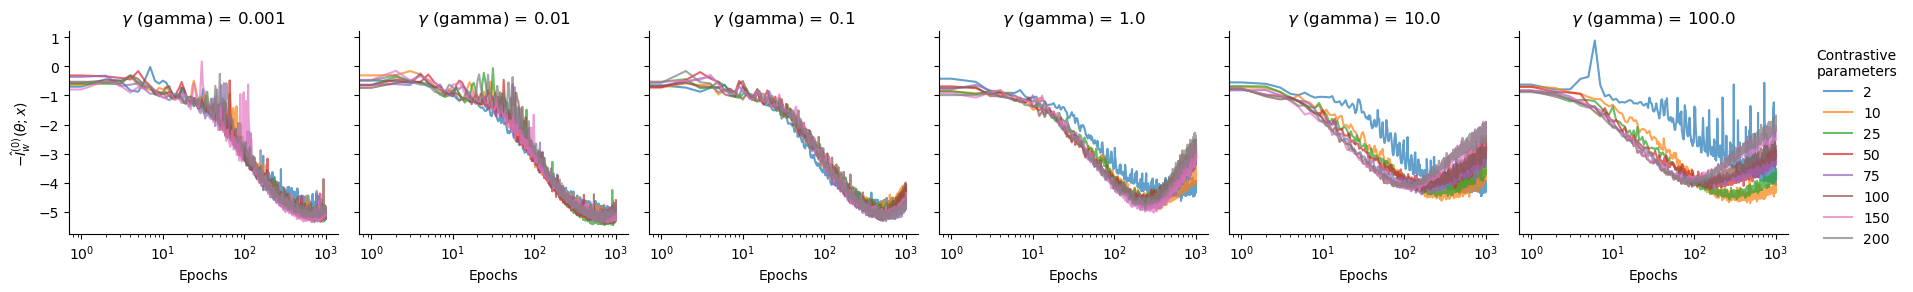

In [9]:
df_sameval = df[
    (df["algorithm"] == "CNRE")
    # | (df["algorithm"] == "NRE-B")
    & (df["task"] == "slcp")
    & (df["num_blocks"] == 3)
].copy()

# df_sameval_copy = df_sameval.copy()
# df_sameval_copy["metric"] = "avglogratio"

df_sameval["metric"] = "mi0"

# df_sameval = pd.concat([df_sameval, df_sameval_copy], ignore_index=True)
grp = df_sameval.groupby(["task", "algorithm", "gamma", "num_blocks", "num_contrastive_parameters", "metric"])
df_sameval = grp.first().reset_index()

g = sns.FacetGrid(
    df_sameval, 
    # x="path",  #to look up series
    hue="num_contrastive_parameters",
    row="metric",
    col="gamma", 
    height=3,
    sharey="row",
    # legend_out=True,
    legend_out=False
)

g.figure.tight_layout()
g.map(plot_either_val_or_avglogratio_or_mi, "path", "metric", "num_blocks")

g.add_legend()
sns.move_legend(g, "center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
g.legend.set_title(legend_title)

print(g.axes_dict.keys())
# ax = g.axes_dict[('avglogratio', 0.001)]
# ax.set_ylabel(avglogratio_name)

ax = g.axes_dict[('mi0', 0.001)]
ax.set_ylabel(mi0_axes_label)

for ax in g.axes[0, :]:
    value = ax.get_title().split()[-1]
    ax.set_title(fr"$\gamma$ (gamma) = {value}")
    ax.set_xlabel("Epochs")

ylim = ax.get_ylim()
plt.savefig("mi0-slcp-nrec.pdf", dpi=300, bbox_inches="tight")

dict_keys([('mi1', 0.001), ('mi1', 0.01), ('mi1', 0.1), ('mi1', 1.0), ('mi1', 10.0), ('mi1', 100.0)])


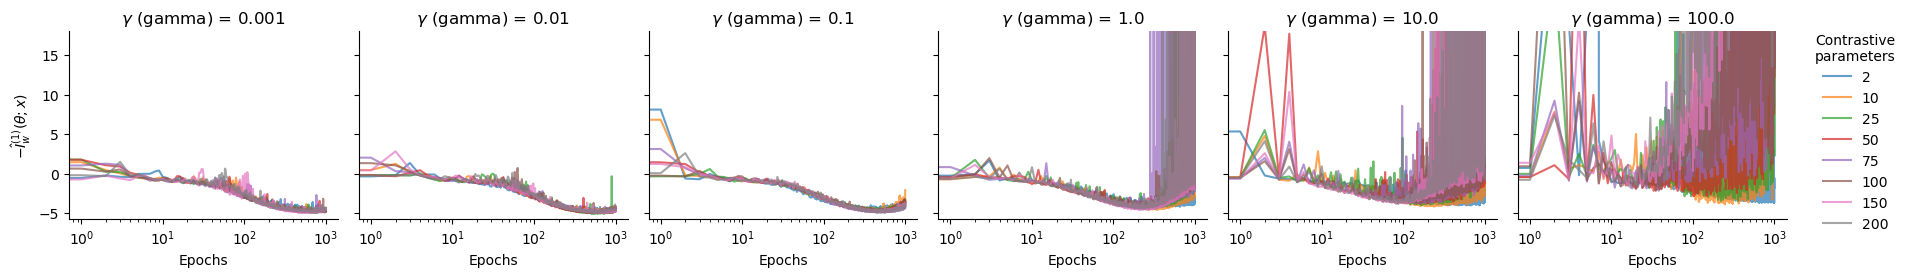

In [10]:
df_sameval = df[
    (df["algorithm"] == "CNRE")
    # | (df["algorithm"] == "NRE-B")
    & (df["task"] == "slcp")
    & (df["num_blocks"] == 3)
].copy()

# df_sameval_copy = df_sameval.copy()
# df_sameval_copy["metric"] = "avglogratio"

df_sameval["metric"] = "mi1"

# df_sameval = pd.concat([df_sameval, df_sameval_copy], ignore_index=True)
grp = df_sameval.groupby(["task", "algorithm", "gamma", "num_blocks", "num_contrastive_parameters", "metric"])
df_sameval = grp.first().reset_index()

g = sns.FacetGrid(
    df_sameval, 
    # x="path",  #to look up series
    hue="num_contrastive_parameters",
    row="metric",
    col="gamma", 
    height=3,
    sharey="row",
    # legend_out=True,
    legend_out=False
)

g.figure.tight_layout()
g.map(plot_either_val_or_avglogratio_or_mi, "path", "metric", "num_blocks")

g.add_legend()
sns.move_legend(g, "center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
g.legend.set_title(legend_title)

print(g.axes_dict.keys())
# ax = g.axes_dict[('avglogratio', 0.001)]
# ax.set_ylabel(avglogratio_name)

ax = g.axes_dict[('mi1', 0.001)]
ax.set_ylabel(mi1_axes_label)

for ax in g.axes[0, :]:
    value = ax.get_title().split()[-1]
    ax.set_title(fr"$\gamma$ (gamma) = {value}")
    ax.set_xlabel("Epochs")
    ax.set_ylim(ylim[0], ylim[1] * 15)

# ylim = ax.get_ylim()
plt.savefig("mi1-slcp-nrec.pdf", dpi=300, bbox_inches="tight")

dict_keys(['mi0'])


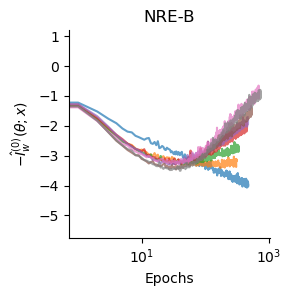

In [11]:
df_nreb = df[
    (df["algorithm"] == "NRE-B")
    & (df["task"] == "slcp")
    & (df["num_blocks"] == 3)
].copy()

df_nreb["metric"] = "mi0"

grp = df_nreb.groupby(["task", "algorithm", "num_blocks", "num_contrastive_parameters", "metric"])
df_sameval = grp.first().reset_index()

g = sns.FacetGrid(
    df_sameval, 
    # x="path",  #to look up series
    hue="num_contrastive_parameters",
    row="metric",
    # col="gamma", 
    height=3.05,
    sharey="row",
    # legend_out=True,
    legend_out=False
)

g.figure.tight_layout()
g.map(plot_either_val_or_avglogratio_or_mi, "path", "metric", "num_blocks")

# g.add_legend()
# sns.move_legend(g, "center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
# g.legend.set_title(legend_title)

print(g.axes_dict.keys())
# ax = g.axes_dict[('avglogratio', 0.001)]
# ax.set_ylabel(avglogratio_name)

ax = g.axes_dict[('mi0')]
ax.set_ylabel(mi0_axes_label)
ax.set_ylim(*ylim)

for ax in g.axes[0, :]:
    value = ax.get_title().split()[-1]
    ax.set_title(r"NRE-B")
    ax.set_xlabel("Epochs")

plt.savefig("mi0-slcp-nreb.pdf", dpi=300, bbox_inches="tight")

dict_keys(['mi1'])


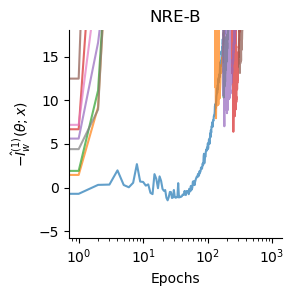

In [12]:
df_nreb = df[
    (df["algorithm"] == "NRE-B")
    & (df["task"] == "slcp")
    & (df["num_blocks"] == 3)
].copy()

df_nreb["metric"] = "mi1"

grp = df_nreb.groupby(["task", "algorithm", "num_blocks", "num_contrastive_parameters", "metric"])
df_sameval = grp.first().reset_index()

g = sns.FacetGrid(
    df_sameval, 
    # x="path",  #to look up series
    hue="num_contrastive_parameters",
    row="metric",
    # col="gamma", 
    height=3.05,
    sharey="row",
    # legend_out=True,
    legend_out=False
)

g.figure.tight_layout()
g.map(plot_either_val_or_avglogratio_or_mi, "path", "metric", "num_blocks")

# g.add_legend()
# sns.move_legend(g, "center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
# g.legend.set_title(legend_title)

print(g.axes_dict.keys())
# ax = g.axes_dict[('avglogratio', 0.001)]
# ax.set_ylabel(avglogratio_name)

ax = g.axes_dict[('mi1')]
ax.set_ylabel(mi1_axes_label)
# ax.set_ylim(*ylim)
ax.set_ylim(ylim[0], ylim[1] * 15)

for ax in g.axes[0, :]:
    value = ax.get_title().split()[-1]
    ax.set_title(r"NRE-B")
    ax.set_xlabel("Epochs")

plt.savefig("mi1-slcp-nreb.pdf", dpi=300, bbox_inches="tight")

## mutual information (summarized)

dict_keys([('mi0', 0.001), ('mi0', 1.0), ('mi0', 100.0)])


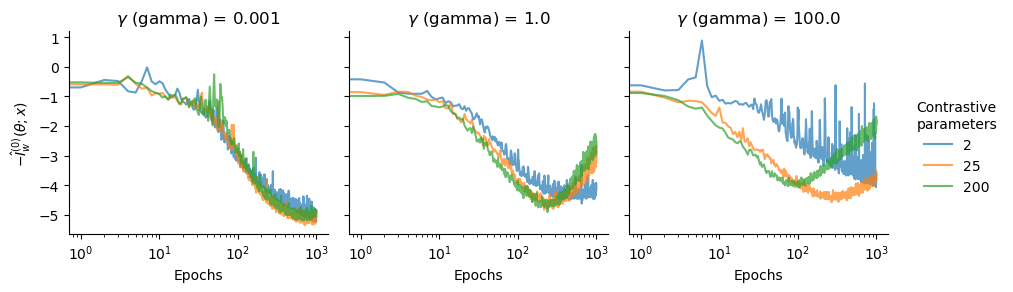

In [13]:
df_sameval = df[
    (df["algorithm"] == "CNRE")
    # | (df["algorithm"] == "NRE-B")
    & (df["task"] == "slcp")
    & (df["num_blocks"] == 3)
    & (df["gamma"].isin([1e-3, 1., 100]))
    & (df["num_contrastive_parameters"].isin([2, 25, 200]))
].copy()

# df_sameval_copy = df_sameval.copy()
# df_sameval_copy["metric"] = "avglogratio"

df_sameval["metric"] = "mi0"

# df_sameval = pd.concat([df_sameval, df_sameval_copy], ignore_index=True)
grp = df_sameval.groupby(["task", "algorithm", "gamma", "num_blocks", "num_contrastive_parameters", "metric"])
df_sameval = grp.first().reset_index()

g = sns.FacetGrid(
    df_sameval, 
    # x="path",  #to look up series
    hue="num_contrastive_parameters",
    row="metric",
    col="gamma", 
    height=3,
    sharey="row",
    # legend_out=True,
    legend_out=False
)

g.figure.tight_layout()
g.map(plot_either_val_or_avglogratio_or_mi, "path", "metric", "num_blocks")

g.add_legend()
sns.move_legend(g, "center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
g.legend.set_title(legend_title)

print(g.axes_dict.keys())
# ax = g.axes_dict[('avglogratio', 0.001)]
# ax.set_ylabel(avglogratio_name)

ax = g.axes_dict[('mi0', 0.001)]
ax.set_ylabel(mi0_axes_label)

for ax in g.axes[0, :]:
    value = ax.get_title().split()[-1]
    ax.set_title(fr"$\gamma$ (gamma) = {value}")
    ax.set_xlabel("Epochs")

ylim = ax.get_ylim()
plt.savefig("mi0-slcp-nrec-summary.pdf", dpi=300, bbox_inches="tight")

dict_keys([('mi1', 0.001), ('mi1', 1.0), ('mi1', 100.0)])


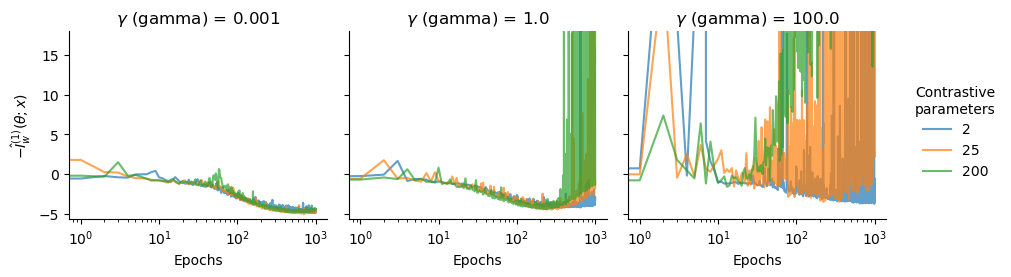

In [14]:
# ######
# # MI 1
# ######
df_sameval = df[
    (df["algorithm"] == "CNRE")
    # | (df["algorithm"] == "NRE-B")
    & (df["task"] == "slcp")
    & (df["num_blocks"] == 3)
    & (df["gamma"].isin([1e-3, 1., 100]))
    & (df["num_contrastive_parameters"].isin([2, 25, 200]))
].copy()

# df_sameval_copy = df_sameval.copy()
# df_sameval_copy["metric"] = "avglogratio"

df_sameval["metric"] = "mi1"

# df_sameval = pd.concat([df_sameval, df_sameval_copy], ignore_index=True)
grp = df_sameval.groupby(["task", "algorithm", "gamma", "num_blocks", "num_contrastive_parameters", "metric"])
df_sameval = grp.first().reset_index()

g = sns.FacetGrid(
    df_sameval, 
    # x="path",  #to look up series
    hue="num_contrastive_parameters",
    row="metric",
    col="gamma", 
    height=3,
    sharey="row",
    # legend_out=True,
    legend_out=False
)

g.figure.tight_layout()
g.map(plot_either_val_or_avglogratio_or_mi, "path", "metric", "num_blocks")

g.add_legend()
sns.move_legend(g, "center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
g.legend.set_title(legend_title)

print(g.axes_dict.keys())
# ax = g.axes_dict[('avglogratio', 0.001)]
# ax.set_ylabel(avglogratio_name)

ax = g.axes_dict[('mi1', 0.001)]
ax.set_ylabel(mi1_axes_label)

for ax in g.axes[0, :]:
    value = ax.get_title().split()[-1]
    ax.set_title(fr"$\gamma$ (gamma) = {value}")
    ax.set_xlabel("Epochs")
    ax.set_ylim(ylim[0], ylim[1] * 15)

# ylim = ax.get_ylim()
plt.savefig("mi1-slcp-nrec-summary.pdf", dpi=300, bbox_inches="tight")

dict_keys(['mi0'])


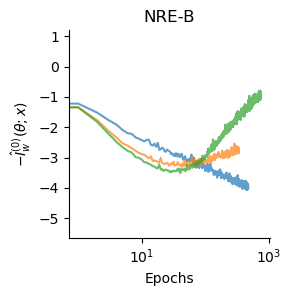

In [15]:
df_nreb = df[
    (df["algorithm"] == "NRE-B")
    & (df["task"] == "slcp")
    & (df["num_blocks"] == 3)
    # & (df["num_contrastive_parameters"].isin([2, 10, 25, 200]))
    & (df["num_contrastive_parameters"].isin([2, 25, 200]))
].copy()

df_nreb["metric"] = "mi0"

grp = df_nreb.groupby(["task", "algorithm", "num_blocks", "num_contrastive_parameters", "metric"])
df_sameval = grp.first().reset_index()

g = sns.FacetGrid(
    df_sameval, 
    # x="path",  #to look up series
    hue="num_contrastive_parameters",
    row="metric",
    # col="gamma", 
    height=3.05,
    sharey="row",
    # legend_out=True,
    legend_out=False
)

g.figure.tight_layout()
g.map(plot_either_val_or_avglogratio_or_mi, "path", "metric", "num_blocks")

# g.add_legend()
# sns.move_legend(g, "center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
# g.legend.set_title(legend_title)

print(g.axes_dict.keys())
# ax = g.axes_dict[('avglogratio', 0.001)]
# ax.set_ylabel(avglogratio_name)

ax = g.axes_dict[('mi0')]
ax.set_ylabel(mi0_axes_label)
ax.set_ylim(*ylim)

for ax in g.axes[0, :]:
    value = ax.get_title().split()[-1]
    ax.set_title(r"NRE-B")
    ax.set_xlabel("Epochs")

plt.savefig("mi0-slcp-nreb-summary.pdf", dpi=300, bbox_inches="tight")

dict_keys(['mi1'])


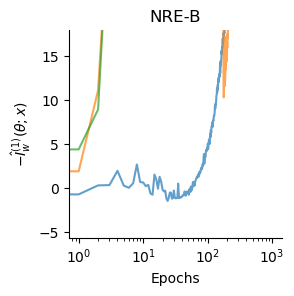

In [16]:
df_nreb = df[
    (df["algorithm"] == "NRE-B")
    & (df["task"] == "slcp")
    & (df["num_blocks"] == 3)
    # & (df["num_contrastive_parameters"].isin([2, 10, 25, 200]))
    & (df["num_contrastive_parameters"].isin([2, 25, 200]))
].copy()

df_nreb["metric"] = "mi1"

grp = df_nreb.groupby(["task", "algorithm", "num_blocks", "num_contrastive_parameters", "metric"])
df_sameval = grp.first().reset_index()

g = sns.FacetGrid(
    df_sameval, 
    # x="path",  #to look up series
    hue="num_contrastive_parameters",
    row="metric",
    # col="gamma", 
    height=3.05,
    sharey="row",
    # legend_out=True,
    legend_out=False
)

g.figure.tight_layout()
g.map(plot_either_val_or_avglogratio_or_mi, "path", "metric", "num_blocks")

# g.add_legend()
# sns.move_legend(g, "center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
# g.legend.set_title(legend_title)

print(g.axes_dict.keys())
# ax = g.axes_dict[('avglogratio', 0.001)]
# ax.set_ylabel(avglogratio_name)

ax = g.axes_dict[('mi1')]
ax.set_ylabel(mi1_axes_label)
ax.set_ylim(ylim[0], ylim[1] * 15)

for ax in g.axes[0, :]:
    value = ax.get_title().split()[-1]
    ax.set_title(r"NRE-B")
    ax.set_xlabel("Epochs")

plt.savefig("mi1-slcp-nreb-summary.pdf", dpi=300, bbox_inches="tight")

## compare to c2st

In [17]:
df_wide, grp = wide_to_long(df)

In [18]:
df_minmi0 = df_wide.reset_index()
# df_minmi0["min_mi0"] = df_minmi0["path"].map(lambda x: get_tensor_from_csv(Path(x) / "mutual_information_0s.csv").neg().min().numpy())
df_minmi0["min_mi0"] = df_minmi0["path"].map(lambda x: np.nanmin(get_tensor_from_csv(Path(x) / "mutual_information_0s.csv").neg().squeeze().numpy()))

group_cols = ["gamma", "num_contrastive_parameters"]
cols = ["num_contrastive_parameters", "gamma", "C2ST_Z"]

df_c2st = grp.aggregate(
    {"C2ST_Z": ["mean"], 
     # "path": ["first"]
    }
).reset_index()
df_c2st = df_c2st[cols].groupby(group_cols).first()

df_minmi0 = df_minmi0.groupby(group_cols).aggregate(
    {"min_mi0": ["mean"],
    }
)


df_combi = pd.concat(
    [df_c2st, df_minmi0],
    axis = 1,
)
df_combi = df_combi.reset_index()
df_combi = df_combi[df_combi["gamma"] != float("inf")]
df_combi.columns = df_combi.columns.get_level_values(0)
print(df_combi.columns)

Index(['gamma', 'num_contrastive_parameters', 'C2ST_Z', 'min_mi0'], dtype='object')


/tmp/ipykernel_164794/1623141701.py:13: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_c2st = df_c2st[cols].groupby(group_cols).first()


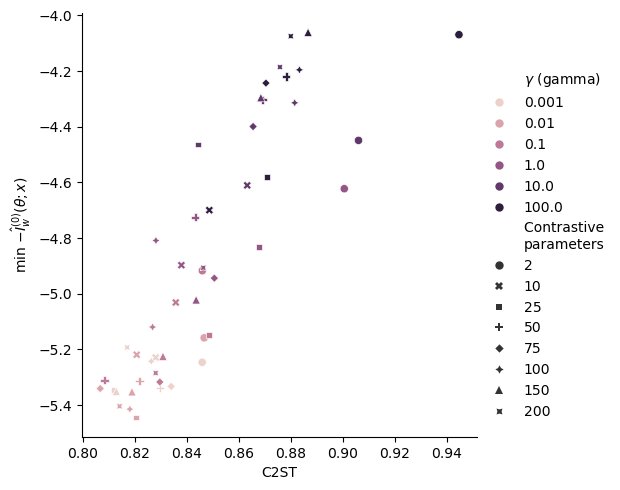

In [19]:
k_name = 'Contrastive \nparameters'
c2st_name = 'C2ST'
gamma_name = r"$\gamma$ (gamma)"
min_mi0_axes_label = "min " + mi0_axes_label
df_combi.columns = [gamma_name, k_name, c2st_name, min_mi0_axes_label]

fg = sns.relplot(
    data=df_combi,
    x=c2st_name,
    y=min_mi0_axes_label,
    hue=gamma_name,
    style=k_name,
    # style_order=["NRE-C", "NRE-B"],
    # row="",
    # row_order=['slcp', 'two_moons', 'gaussian_mixture', 'average'],
    # col="num_contrastive_parameters",
    # kind="line",
    hue_norm=LogNorm(),
    height=5,
    # legend=False,
)

ax = fg.axes[0, 0]

ax.set_ylabel(min_mi0_axes_label)
ax.set_xlabel("C2ST")

plt.savefig("mi0-c2st-correlation.pdf", dpi=300, bbox_inches="tight")